In [180]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


# Data Cleaning

In [181]:
data_path = '/Users/Maggie/Desktop/Machine Learning/ClassificationProject/telecom_churn.csv'
unclean_data = pd.read_csv(data_path)

print("-------------------- Data Summary --------------------")
# Show basic data summary about size and first three entries
print("Shape:", unclean_data.shape)
print("\nFirst 3 Entries:\n", unclean_data.head(3))
print("\nColumn Names:\n", unclean_data.columns)

# Calculate and display percent of missing values per columns
print("\nPercent of Missing Values in Each Column:\n", unclean_data.isna().sum() / len(unclean_data) * 100) 

# Calculate and display percent of missing values per row
percent_missing_per_row = unclean_data.isna().sum(axis=1) / unclean_data.shape[1] * 100
print("\nPercent of Missing Values in Each Row:\n", percent_missing_per_row)

-------------------- Data Summary --------------------
Shape: (3333, 11)

First 3 Entries:
    Churn  AccountWeeks  ContractRenewal  DataPlan  DataUsage  CustServCalls  \
0      0           128                1         1        2.7              1   
1      0           107                1         1        3.7              1   
2      0           137                1         0        0.0              0   

   DayMins  DayCalls  MonthlyCharge  OverageFee  RoamMins  
0    265.1       110           89.0        9.87      10.0  
1    161.6       123           82.0        9.78      13.7  
2    243.4       114           52.0        6.06      12.2  

Column Names:
 Index(['Churn', 'AccountWeeks', 'ContractRenewal', 'DataPlan', 'DataUsage',
       'CustServCalls', 'DayMins', 'DayCalls', 'MonthlyCharge', 'OverageFee',
       'RoamMins'],
      dtype='object')

Percent of Missing Values in Each Column:
 Churn              0.0
AccountWeeks       0.0
ContractRenewal    0.0
DataPlan           0.0
Dat

In [182]:
# Separate numerical and categorical columns
numerical_df = unclean_data.select_dtypes(include='number')
categorical_df = unclean_data.select_dtypes(exclude='number')

print("Numerical column names:\n")
print(numerical_df.columns)

print("\nCategorical column names:\n")
print(categorical_df.columns)

# Make target categorical
numerical_df['Churn'] = numerical_df['Churn'].astype('category')

Numerical column names:

Index(['Churn', 'AccountWeeks', 'ContractRenewal', 'DataPlan', 'DataUsage',
       'CustServCalls', 'DayMins', 'DayCalls', 'MonthlyCharge', 'OverageFee',
       'RoamMins'],
      dtype='object')

Categorical column names:

Index([], dtype='object')


In [183]:
# Split into target and features
y = numerical_df['Churn']
X = numerical_df.drop(['Churn'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.info()
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2333 entries, 2016 to 3174
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   AccountWeeks     2333 non-null   int64  
 1   ContractRenewal  2333 non-null   int64  
 2   DataPlan         2333 non-null   int64  
 3   DataUsage        2333 non-null   float64
 4   CustServCalls    2333 non-null   int64  
 5   DayMins          2333 non-null   float64
 6   DayCalls         2333 non-null   int64  
 7   MonthlyCharge    2333 non-null   float64
 8   OverageFee       2333 non-null   float64
 9   RoamMins         2333 non-null   float64
dtypes: float64(5), int64(5)
memory usage: 200.5 KB
<class 'pandas.core.series.Series'>
Index: 2333 entries, 2016 to 3174
Series name: Churn
Non-Null Count  Dtype   
--------------  -----   
2333 non-null   category
dtypes: category(1)
memory usage: 20.6 KB


## Function Definitions

In [184]:
# function to calculate perofrmance from sklearn logistic regression models
def performance_rpt(model, X_test, y_test):
    # Calculate performance metrics using the provided model
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    y_true = y_test
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    aucroc = roc_auc_score(y_test, y_proba)

    # Print the performance metrics
    #print(" -- Model Performance on Test Set --")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"AUC-ROC  : {aucroc:.4f}\n")

    return accuracy, precision, recall, aucroc

# function for model coefficents from sklearn logistic regression
def rpt_model_variables(model):
    # Get the intercept term
    intercept = model.intercept_

    # Access the coefficients (weights) of the model, i rounded them
    coefficients = np.round(model.coef_[0],decimals=4)

    # Create DataFrames for intercept and coefficients
    #df_intercept = pd.DataFrame({'feature': ['Intercept'], 'coefficient': [intercept[0]]})
    df_coefficients = pd.DataFrame({'feature': X.columns, 'coefficient': coefficients})
    df_coefficients['abs_coefficient'] = df_coefficients['coefficient'].abs()
    df_coefficients.sort_values(by='abs_coefficient', ascending=False, inplace=True)

    # if you want to add intercept to table
    #df_model = pd.concat([df_intercept, df_coefficients]).reset_index(drop=True)

    # Print the DataFrame
    print(df_coefficients)

    return df_coefficients

# plot variable importance for sklearn logistic regression
def plot_variable_imp(df_coef):
  df_plt = df_coef[df_coef['abs_coefficient'] != 0]
  reject_vars = df_coef[df_coef['abs_coefficient'] == 0]['feature'].tolist()

  plt.figure(figsize=(5, 10))
  plt.title('Variable Importance')
  plt.xlabel('Coefficient')
  plt.ylabel('Feature')
  sns.barplot(data=df_plt,
                     y=df_plt['feature'],
                     x=df_plt['abs_coefficient'], color="lightblue")

  plt.show()
  print("-- rejected --")
  for i in reject_vars:
    print(f" {i}")

# Model Building
### First Logistic Regression (Full Model) - Harry

In [185]:
#Fit full logistic regression model to examine the significance of the terms
X1 = X_train
X1 = sm.add_constant(X1)
y1 = y_train

logit_full = sm.Logit(y1, X1).fit()

#Print summary
print(logit_full.summary())

Optimization terminated successfully.
         Current function value: 0.330579
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 2333
Model:                          Logit   Df Residuals:                     2322
Method:                           MLE   Df Model:                           10
Date:                Thu, 14 Nov 2024   Pseudo R-squ.:                  0.2039
Time:                        13:46:26   Log-Likelihood:                -771.24
converged:                       True   LL-Null:                       -968.75
Covariance Type:            nonrobust   LLR p-value:                 1.078e-78
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -5.3633      0.656     -8.179      0.000      -6.649      -4.078
AccountWeeks  

In [186]:
# Evaluate Model 

# Create copies for use
X_test1 = X_test.copy()
X_train1 = X_train.copy()

# Generate predicted values for training set
pprob = logit_full.predict(X1)

# Create predicted category for success using 50% cutoff
psuccess = (pprob > 0.5).astype(int)

# Add new variables to the training data set
X_train1['p_success'] = psuccess
X_train1['p_prob'] = pprob
X_train1['y'] = y_train


# Generate predicted values for test set

X_test1 = sm.add_constant(X_test1)

pprob_test = logit_full.predict(X_test1)

# Create predicted category for success using 50% cutoff
psuccess_test = (pprob_test > 0.5).astype(int)

# Add new variables to the response data set
X_test1['p_success'] = psuccess_test
X_test1['p_prob'] = pprob_test

In [187]:
# Generate confusion matrix for training set
conf_matrix = confusion_matrix(psuccess, y_train)
print("Confusion Matrix for Training Data")
print(conf_matrix)

# Generate confusion matrix for test set
conf_matrix = confusion_matrix(psuccess_test, y_test)
print("\nConfusion Matrix for Testing Data")
print(conf_matrix)

Confusion Matrix for Training Data
[[1937  275]
 [  56   65]]

Confusion Matrix for Testing Data
[[838 114]
 [ 19  29]]


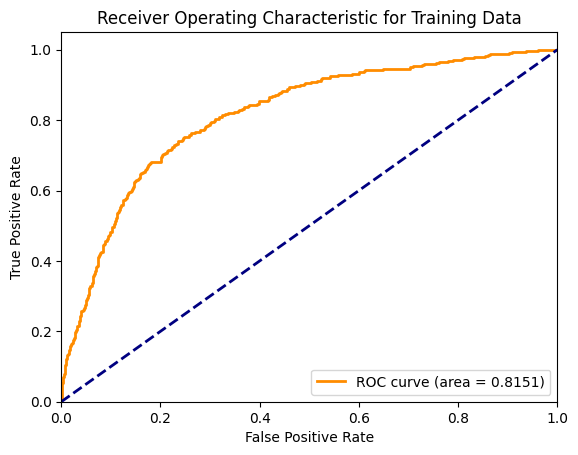

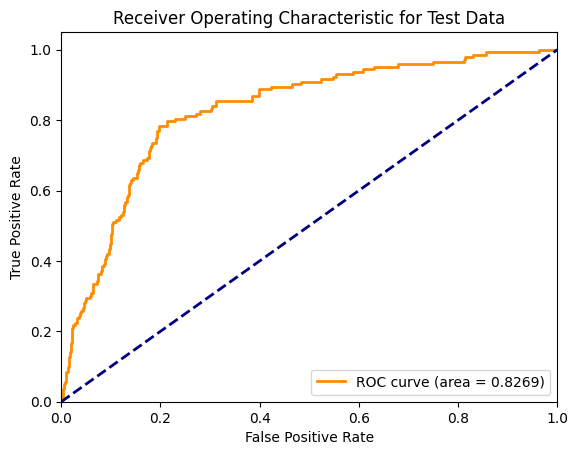

In [188]:
# Generate ROC curve for training data
fpr, tpr, thresholds = roc_curve(y_train.cat.codes, pprob)
roc_auc = roc_auc_score(y_train.cat.codes, pprob)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Training Data')
plt.legend(loc='lower right')
plt.show()

# Generate ROC curve for test data
fpr, tpr, thresholds = roc_curve(y_test.cat.codes, pprob_test)
roc_auc = roc_auc_score(y_test.cat.codes, pprob_test)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Test Data')
plt.legend(loc='lower right')
plt.show()

### Second Logistic Regression (L1 Regularization)

In [189]:
# Create an Instance of Logistic Regression for LASSO Selection
X2_train = X_train.copy()
X2_test = X_test.copy()

lr_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=0.1)

# fit the models to the training data
lr_l1.fit(X2_train, y_train)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

           feature  coefficient  abs_coefficient
1  ContractRenewal      -2.0241           2.0241
4    CustServCalls       0.4051           0.4051
8       OverageFee       0.0915           0.0915
9         RoamMins       0.0435           0.0435
7    MonthlyCharge      -0.0272           0.0272
5          DayMins       0.0128           0.0128
6         DayCalls      -0.0102           0.0102
0     AccountWeeks      -0.0020           0.0020
2         DataPlan       0.0000           0.0000
3        DataUsage       0.0000           0.0000


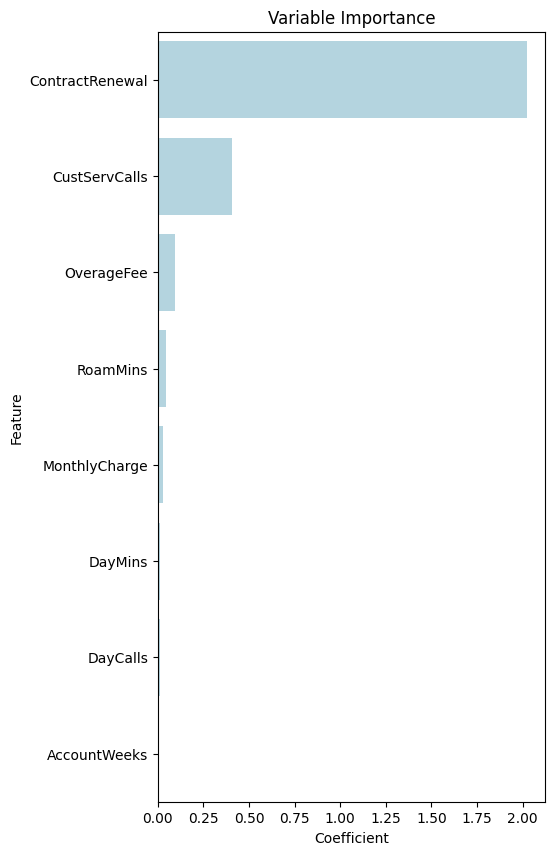

-- rejected --
 DataPlan
 DataUsage
Accuracy : 0.8573
Precision: 0.5376
Recall   : 0.1471
AUC-ROC  : 0.8048

Accuracy : 0.8560
Precision: 0.4884
Recall   : 0.1469
AUC-ROC  : 0.8099



In [190]:
#Print a list of variable names and coefficients from the model
df_coefficients1 = rpt_model_variables(lr_l1)

#Plot the variable importance (larger indicates that the variable is more significant) for each variable in the model
plot_variable_imp(df_coefficients1)

#Generate the assessment statistics for the training data set
accuracy, precision, recall, auroc = performance_rpt(lr_l1, X2_train, y_train)
#Generate the assessment statistics for the test data set
accuracy, precision, recall, auroc = performance_rpt(lr_l1, X2_test, y_test)

### Third Logistic Regression (L2 Regularization)

In [191]:
# Create an Instance of Logistic Regression for Ridge Regression (L2 regularization)
X3_train = X_train.copy()
X3_test = X_test.copy()

lr_l2 = LogisticRegression(penalty='l2', solver='liblinear')


# fit the models to the training data
lr_l2.fit(X3_train, y_train)

LogisticRegression(solver='liblinear')

           feature  coefficient  abs_coefficient
1  ContractRenewal      -2.1099           2.1099
2         DataPlan      -0.9294           0.9294
4    CustServCalls       0.4642           0.4642
8       OverageFee       0.1142           0.1142
3        DataUsage       0.1111           0.1111
9         RoamMins       0.0706           0.0706
5          DayMins       0.0117           0.0117
7    MonthlyCharge      -0.0090           0.0090
6         DayCalls      -0.0043           0.0043
0     AccountWeeks      -0.0006           0.0006


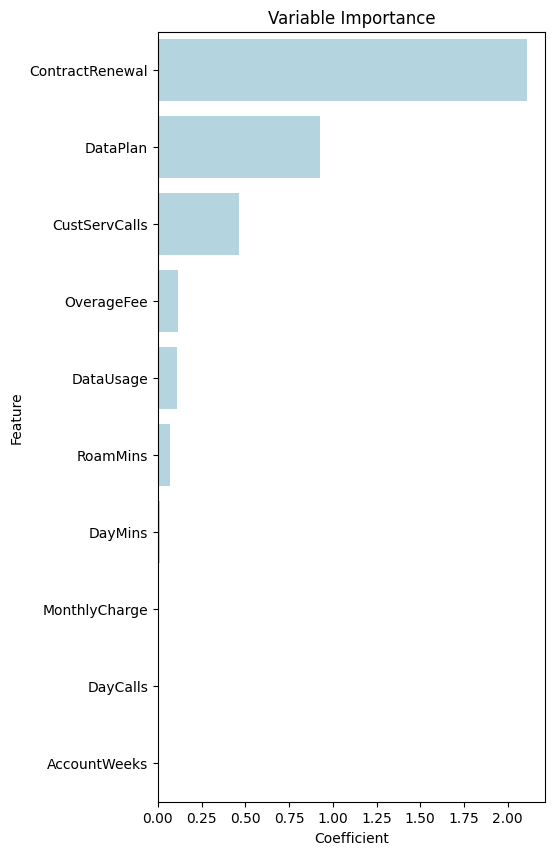

-- rejected --
Accuracy : 0.8590
Precision: 0.5534
Recall   : 0.1676
AUC-ROC  : 0.8153

Accuracy : 0.8580
Precision: 0.5102
Recall   : 0.1748
AUC-ROC  : 0.8250



In [192]:
#Print a list of variable names and coefficients from the model
df_coefficients2 = rpt_model_variables(lr_l2)

#Plot the variable importance (larger indicates that the variable is more significant) for each variable in the model
plot_variable_imp(df_coefficients2)

#Generate the assessment statistics for the training data set
accuracy, precision, recall, auroc = performance_rpt(lr_l2, X3_train, y_train)
#Generate the assessment statistics for the test data set
accuracy, precision, recall, auroc = performance_rpt(lr_l2, X3_test, y_test)

### First Decision Tree (Max_Depth: 5, Min_Samples: 50)

In [193]:
dt_tune = DecisionTreeClassifier()

param_grid = {
    'max_depth': [None, 5, 10, 15, 20, 25],
    'min_samples_leaf': [1, 10, 20, 50, 100],
    'ccp_alpha': [0, 0.001, 0.01, 0.1, 0.5, 1]
}

grid_search = GridSearchCV(dt_tune, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print(best_params)
print(best_estimator)

{'ccp_alpha': 0, 'max_depth': 5, 'min_samples_leaf': 10}
DecisionTreeClassifier(ccp_alpha=0, max_depth=5, min_samples_leaf=10)


In [194]:
# create an instance of a decision tree classifier
X4_train = X_train.copy()
X4_test = X_test.copy()

dt1 = DecisionTreeClassifier(max_depth = 5, min_samples_leaf=50, ccp_alpha = 0)

# fit the model to the training data
dt1.fit(X4_train, y_train)

# this code can be used to produce a textual representation of the tree if desired
#text_rep = tree.export_text(dt)
#print(text_rep)

DecisionTreeClassifier(ccp_alpha=0, max_depth=5, min_samples_leaf=50)

In [195]:
# make predictions on the training and test data
y_pred_train_dt1 = dt1.predict(X4_train)
y_pred_test_dt1 = dt1.predict(X4_test)

y_prob_train_dt1 = dt1.predict_proba(X4_train)
y_prob_test_dt1 = dt1.predict_proba(X4_test)

In [196]:
# calculate the accuracy, precision, and recall scores
acc_train = accuracy_score(y_train, y_pred_train_dt1)
prec_train = precision_score(y_train, y_pred_train_dt1)
rec_train = recall_score(y_train, y_pred_train_dt1)

# print the scores
print(" -- train set -- ")
print("Accuracy : {:.4f}".format(acc_train))
print("Precision: {:.4f}".format(prec_train))
print("Recall.  : {:.4f}".format(rec_train))
print("")

# calculate the accuracy, precision, and recall scores
acc_test = accuracy_score(y_test, y_pred_test_dt1)
prec_test = precision_score(y_test, y_pred_test_dt1)
rec_test = recall_score(y_test, y_pred_test_dt1)

print(" -- test set -- ")
print("Accuracy : {:.4f}".format(acc_test))
print("Precision: {:.4f}".format(prec_test))
print("Recall.  : {:.4f}".format(rec_test))

 -- train set -- 
Accuracy : 0.9143
Precision: 0.7869
Recall.  : 0.5647

 -- test set -- 
Accuracy : 0.9000
Precision: 0.6972
Recall.  : 0.5315


In [197]:
# confusion matrix
conf_matrix = confusion_matrix(y_pred_train_dt1, y_train)
print("Confusion Matrix for Training Data")
print(conf_matrix)

# Generate confusion matrix for test set
conf_matrix = confusion_matrix(y_pred_test_dt1, y_test)
print("\nConfusion Matrix for Testing Data")
print(conf_matrix)

Confusion Matrix for Training Data
[[1941  148]
 [  52  192]]

Confusion Matrix for Testing Data
[[824  67]
 [ 33  76]]


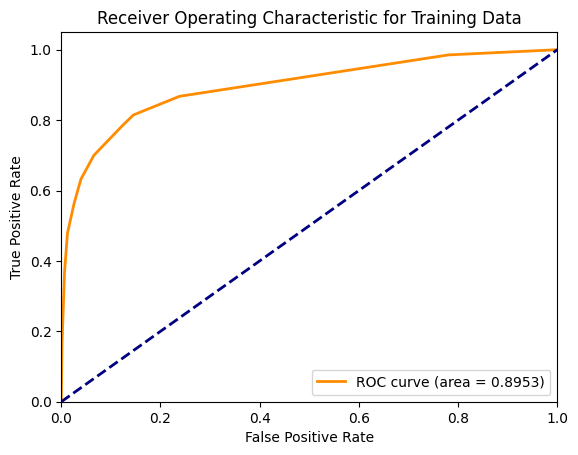

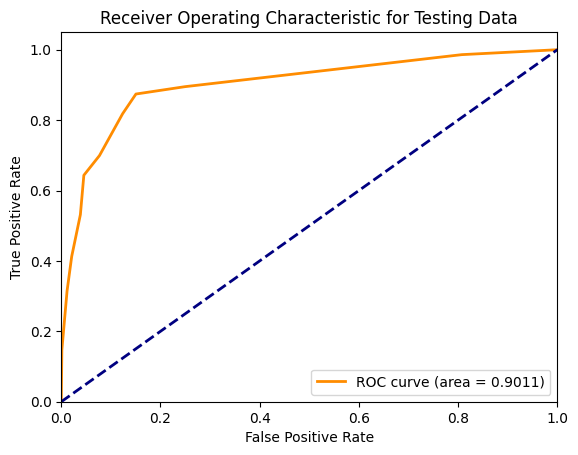

In [198]:
# Generate ROC curve for training data

fpr, tpr, thresholds = roc_curve(y_train.cat.codes, y_prob_train_dt1[:,1])
roc_auc = roc_auc_score(y_train.cat.codes, y_prob_train_dt1[:,1])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Training Data')
plt.legend(loc='lower right')
plt.show()

# Generate ROC curve for testing data

fpr, tpr, thresholds = roc_curve(y_test.cat.codes, y_prob_test_dt1[:,1])
roc_auc = roc_auc_score(y_test.cat.codes, y_prob_test_dt1[:,1])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Testing Data')
plt.legend(loc='lower right')
plt.show()

   importance          feature
5    0.396472          DayMins
4    0.211586    CustServCalls
1    0.144538  ContractRenewal
3    0.072497        DataUsage
9    0.066592         RoamMins
8    0.060758       OverageFee
7    0.047557    MonthlyCharge
0    0.000000     AccountWeeks
2    0.000000         DataPlan
6    0.000000         DayCalls


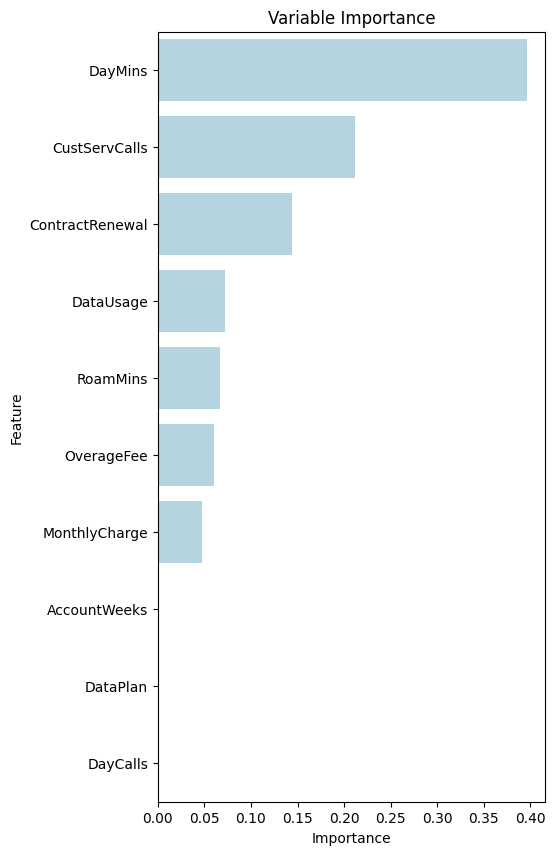

In [199]:
#calculate feature importance
tree_imp = dt1.feature_importances_

#create a data frame with feature names

# creating a list of column names
column_values = ['importance']

# creating the dataframe
df_dt1 = pd.DataFrame(data = tree_imp,
                  columns = column_values)
df_dt1['feature']=X.columns

#sort data so features with largest importance values are at the top
df2_dt1 = df_dt1.sort_values(by=['importance'], ascending=False)

print(df2_dt1)

#Create variable importance plot
plt.figure(figsize=(5, 10))
plt.title('Variable Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
sns.barplot(data=df2_dt1,
            y=df2_dt1['feature'],
            x=df2_dt1['importance'], color="lightblue")

plt.show()

### Second Decision Tree (Max_Depth: 10, Min_Samples: 100)

In [200]:
# create an instance of a decision tree classifier
X5_train = X_train.copy()
X5_test = X_test.copy()

dt2 = DecisionTreeClassifier(max_depth = 10, min_samples_leaf=100, ccp_alpha = 0.001)

# fit the model to the training data
dt2.fit(X5_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.001, max_depth=10, min_samples_leaf=100)

In [201]:
# make predictions on the training and test data
y_pred_train_dt2 = dt2.predict(X5_train)
y_pred_test_dt2 = dt2.predict(X5_test)

y_prob_train_dt2 = dt2.predict_proba(X5_train)
y_prob_test_dt2 = dt2.predict_proba(X5_test)

In [202]:
# calculate the accuracy, precision, and recall scores
acc_train = accuracy_score(y_train, y_pred_train_dt2)
prec_train = precision_score(y_train, y_pred_train_dt2)
rec_train = recall_score(y_train, y_pred_train_dt2)

# print the scores
print(" -- train set -- ")
print("Accuracy : {:.4f}".format(acc_train))
print("Precision: {:.4f}".format(prec_train))
print("Recall.  : {:.4f}".format(rec_train))
print("")

# calculate the accuracy, precision, and recall scores
acc_test = accuracy_score(y_test, y_pred_test_dt2)
prec_test = precision_score(y_test, y_pred_test_dt2)
rec_test = recall_score(y_test, y_pred_test_dt2)

print(" -- test set -- ")
print("Accuracy : {:.4f}".format(acc_test))
print("Precision: {:.4f}".format(prec_test))
print("Recall.  : {:.4f}".format(rec_test))

 -- train set -- 
Accuracy : 0.8633
Precision: 0.5315
Recall.  : 0.5206

 -- test set -- 
Accuracy : 0.8790
Precision: 0.5821
Recall.  : 0.5455


In [203]:
# confusion matrix
conf_matrix = confusion_matrix(y_pred_train_dt2, y_train)
print("Confusion Matrix for Training Data")
print(conf_matrix)

# Generate confusion matrix for test set
conf_matrix = confusion_matrix(y_pred_test_dt2, y_test)
print("\nConfusion Matrix for Testing Data")
print(conf_matrix)

Confusion Matrix for Training Data
[[1837  163]
 [ 156  177]]

Confusion Matrix for Testing Data
[[801  65]
 [ 56  78]]


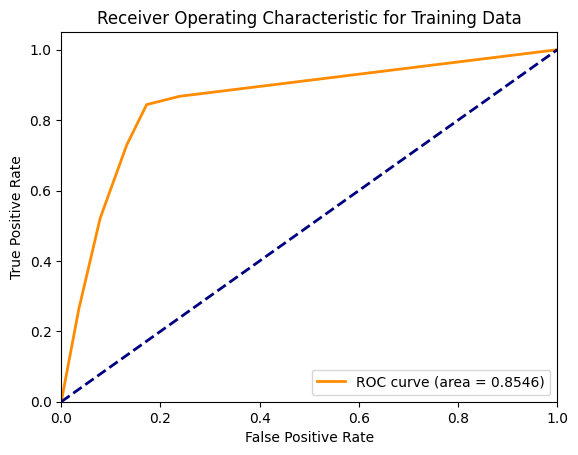

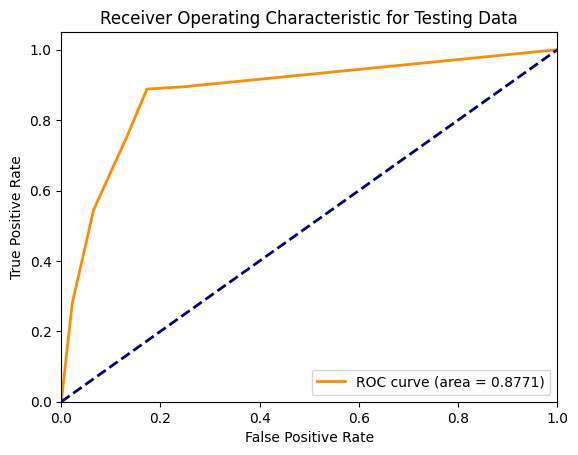

In [204]:
# Generate ROC curve for training data

fpr, tpr, thresholds = roc_curve(y_train.cat.codes, y_prob_train_dt2[:,1])
roc_auc = roc_auc_score(y_train.cat.codes, y_prob_train_dt2[:,1])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Training Data')
plt.legend(loc='lower right')
plt.show()

# Generate ROC curve for testing data

fpr, tpr, thresholds = roc_curve(y_test.cat.codes, y_prob_test_dt2[:,1])
roc_auc = roc_auc_score(y_test.cat.codes, y_prob_test_dt2[:,1])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Testing Data')
plt.legend(loc='lower right')
plt.show()

   importance          feature
5    0.392867          DayMins
4    0.328787    CustServCalls
1    0.224599  ContractRenewal
8    0.053747       OverageFee
0    0.000000     AccountWeeks
3    0.000000        DataUsage
2    0.000000         DataPlan
6    0.000000         DayCalls
7    0.000000    MonthlyCharge
9    0.000000         RoamMins


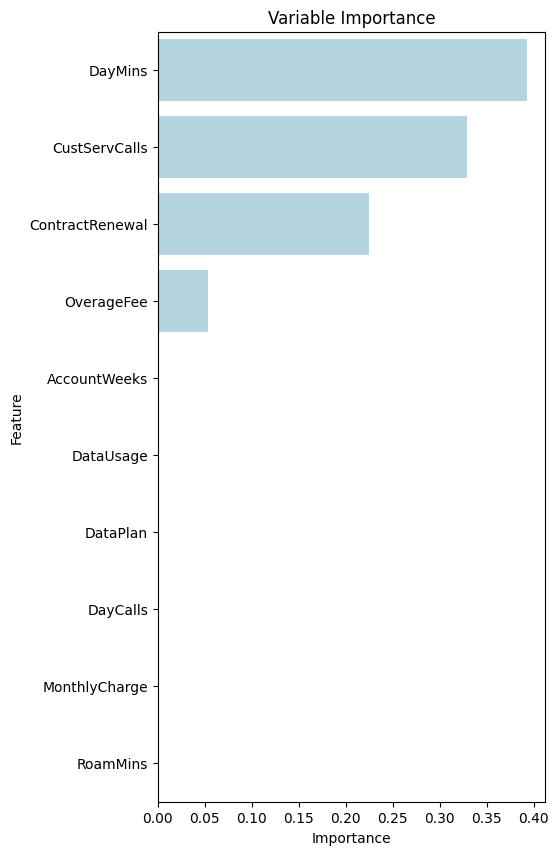

In [205]:
#calculate feature importance
tree_imp = dt2.feature_importances_

#create a data frame with feature names

# creating a list of column names
column_values = ['importance']

# creating the dataframe
df_dt2 = pd.DataFrame(data = tree_imp,
                  columns = column_values)
df_dt2['feature']=X.columns

#sort data so features with largest importance values are at the top
df2_dt2 = df_dt2.sort_values(by=['importance'], ascending=False)

print(df2_dt2)

#Create variable importance plot
plt.figure(figsize=(5, 10))
plt.title('Variable Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
sns.barplot(data=df2_dt2,
            y=df2_dt2['feature'],
            x=df2_dt2['importance'], color="lightblue")

plt.show()